## Robust Shadow Tomography

Robust shadows, as introduced in [Chen et al PRX Q 2021](https://doi.org/10.1103/PRXQuantum.2.030348)  [Koh et al Quantum 2022](https://quantum-journal.org/papers/q-2022-08-16-776/), allow to faithfully estimate physical properties despite the presence of measurement errors. 

In this tutorial, we will use the efficient calibration method based on the experimental demonstration of classical shadows [Vitale et al, arxiv:2307.16882](http://arxiv.org/abs/2307.16882). This calibration is based on on common randomized measurements [Vermersch, al, PRXQ 2024](https://doi.org/10.1103/PRXQuantum.5.010352). 

In [1]:
using Revise
using ITensors,ITensorMPS
using RandomMeas
using ProgressMeter

The calibration of robust classical shadows is based on the preparation of a state $\psi_0$ with very high fidelity. We then perform noisy randomized measurements to learn about the averaged (aka ``twirled'') effect of the noise. 

In [40]:
N = 6
ξ = siteinds("Qubit", N)
states = ["Dn" for n in 1:N]
ψ0  = MPS(ComplexF64,ξ,states);

Under the assumption of a gate independent noise described by a channel $\Lambda=\bigotimes \Lambda_i$, the calibration step will attempt to measure the numbers $G=\frac{1}{2}\sum_{s=0,1}\bra{s}\Lambda_i(\ket{s}\bra{s})\ket{s}\le 1$.

In this example, we simulate numerically this calibration process using  local depolarization channels $\Lambda_i$ with probability $p_i$


In [41]:
p = [max(0, min(0.1 + 0.02 * randn(), 1)) for i in 1:N] #vector of probabilities for each qubit
G = 1 .-p/2; #exact values of G (which we will measure via the calibration stage)

$G$ can be efficiently measured using the randomized measurement estimator provided in [Vitale et al, arxiv:2307.16882](http://arxiv.org/abs/2307.16882)
$$G_e[i]=E_u[\sum_s 3(P_i(s)-\tilde P_i(s)) \tilde P_i(s)+1]$$
where $P_i$ is the measured Born probability, while $\tilde P_i$ is the one what would get in the absence of noise.

In [48]:
Nu=2000 #Number of random unitaries
NM=1000 #Number of projective measurements per unitary

G_e = zeros(Float64,N) #Estimations of G

#In our assumption the state is affected by the depolarization channel during the measurement
ρ0n = apply_depo_channel(ψ0,p)

@showprogress dt=1 for r in 1:Nu
        u = get_rotations(ξ,1) 
        data = get_RandomMeas(ρ0n,u,NM)
        
        #expected state without noise
        ψu = apply(u,ψ0)

        for i in 1:N
            P = get_Born(data[:,i:i],ξ[i:i]) #measured born probability on qubit i
            σui,_ = reduce_dm(ψu,i,i) #expected single qubit density matrix
            Pt = get_Born(σui) #expected born probability
            G_e[i] += real((3*(P-Pt)*Pt)[]+1)/Nu
        end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


We can now check that the measured calibration vector is close to the exact one (or increase the number of measurements to reduce statitical errors)

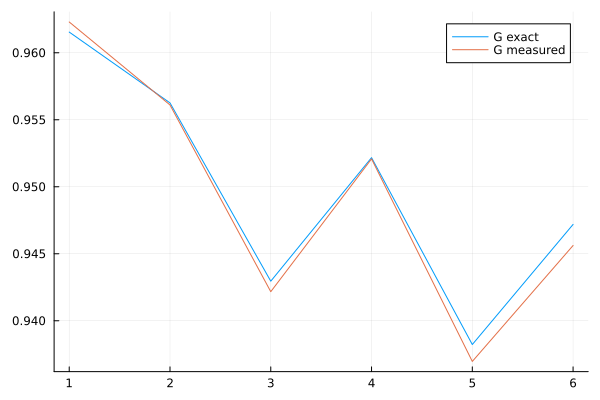

In [49]:
using Plots
plot(G,label="G exact")
plot!(G_e,label="G measured")

The calibration being successful, we are ready to build estimate physical properties for an unknown quantum state using robust shadows

In [50]:
depth = 2
circuit = random_circuit(ξ,depth)
ψ = apply(circuit,ψ0);

In [51]:
u = Vector{Vector{ITensor}}()
data = zeros(Int8,nu,NM,N)
ρn = apply_depo_channel(ψ,p) #as for the calibration, the state is affected by local depolarization during the measurement
@showprogress dt=1 for r in 1:nu
            push!(u,get_rotations(ξ,1)) #generate random unitary
            data[r,:,:] = get_RandomMeas(ρn,u[r],NM) #data acquisation in simulated quantum device
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Let us now try to measure the subsystem purities $\mathrm{tr}(\rho_A^2)$ with non-robust/robust shadows. The second estimator uses the knowledge of the vector $G$ that was estimated during the calibration procedure.

In [52]:
ITensors.disable_warn_order()
purity = zeros(Float64,N)
purity_e = zeros(Float64,N) #purity with non-robust shadows
purity_robust = zeros(Float64,N) #purity with robust shadows

@showprogress dt=1 for NA in 1:N
        purity[NA] = get_purity(ψ,NA)
        uA = [ut[1:NA] for ut in u]
        purity_e[NA] = get_purity_shadows(data[:,:,1:NA],uA,ξ[1:NA])
        purity_robust[NA] = get_purity_shadows(data[:,:,1:NA],uA,ξ[1:NA];G=G_e)

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


We observe that the purity is correctly measured with robust shadows, while non-robust shadows underestimate the value (the intuition is that measurement noise makes the state look effectively more mixed)

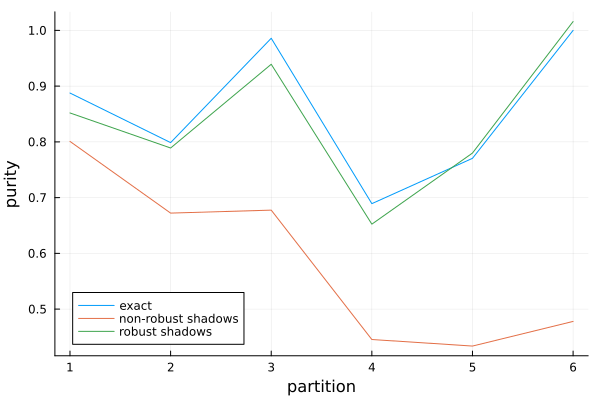

In [53]:
using Plots
plot(1:N,purity,label="exact")
plot!(1:N,purity_e,label="non-robust shadows")
plot!(1:N,purity_robust,label="robust shadows")
xlabel!("partition")
ylabel!("purity")